# Similarity Analysis

This notebook loads pre-computed similarity matrices (or computes them if missing) and provides visualization and analysis tools for comparing models across different bottleneck dimensions.

Three similarity metrics are computed:
1. **TN Similarity** - Weight-space similarity using symmetric inner product
2. **Logit Cosine Similarity** - Output-space similarity based on model logits
3. **JS Divergence** - Frequency distribution similarity from eigenvector FFT analysis

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from pathlib import Path

from models import load_sweep_results, get_device
from tn_sim import load_or_compute_tn_similarity
from act_sim import load_or_compute_act_similarity
from js_div import load_or_compute_js_divergence
from metric_comparison import (
    cosine_similarity_to_metric,
    divergence_to_metric,
    pearson_correlation,
    compute_stress,
    compute_optimal_scale,
    compute_knn_overlap,
    compute_jaccard_index,
    compute_trustworthiness,
    compute_continuity,
    compare_metrics,
    print_comparison_results
)

# Configuration
SWEEP_PATH = Path('../comp_diagrams/sweep_results_0401.pkl')
DEVICE = get_device()
print(f'Device: {DEVICE}')

Device: cuda


## Load Data and Similarity Matrices

The `load_or_compute_*` functions will load from cache if available, or compute and save to cache.

In [2]:
# Load sweep results
models_state, val_acc, P = load_sweep_results(SWEEP_PATH)
print(f'Loaded {len(models_state)} models with P={P}')

# Load/compute similarity matrices
tn_sim_mat = load_or_compute_tn_similarity(SWEEP_PATH, device=DEVICE)
act_sim_mat = load_or_compute_act_similarity(SWEEP_PATH, device=DEVICE)
js_div_mat = load_or_compute_js_divergence(SWEEP_PATH, device=DEVICE)

print(f'\nMatrix shapes:')
print(f'  TN similarity: {tn_sim_mat.shape}')
print(f'  Activation similarity: {act_sim_mat.shape}')
print(f'  JS divergence: {js_div_mat.shape}')

Loaded 64 models with P=64
Computing TN similarity matrix...


Computing TN similarity: 100%|██████████| 64/64 [00:05<00:00, 12.22it/s]


Saved TN similarity to cache: ../comp_diagrams/tn_similarity_matrix.npy
Computing activation similarity matrix...


Computing logit similarity: 100%|██████████| 64/64 [00:00<00:00, 136.94it/s]


Saved activation similarity to cache: ../comp_diagrams/act_similarity_matrix.npy
Computing JS divergence matrix...


Computing JS divergence: 100%|██████████| 64/64 [00:03<00:00, 16.86it/s]

Saved JS divergence to cache: ../comp_diagrams/js_divergence_matrix.npy

Matrix shapes:
  TN similarity: (64, 64)
  Activation similarity: (64, 64)
  JS divergence: (64, 64)


## Validation Accuracy Curve

Reference plot showing model performance across bottleneck dimensions.

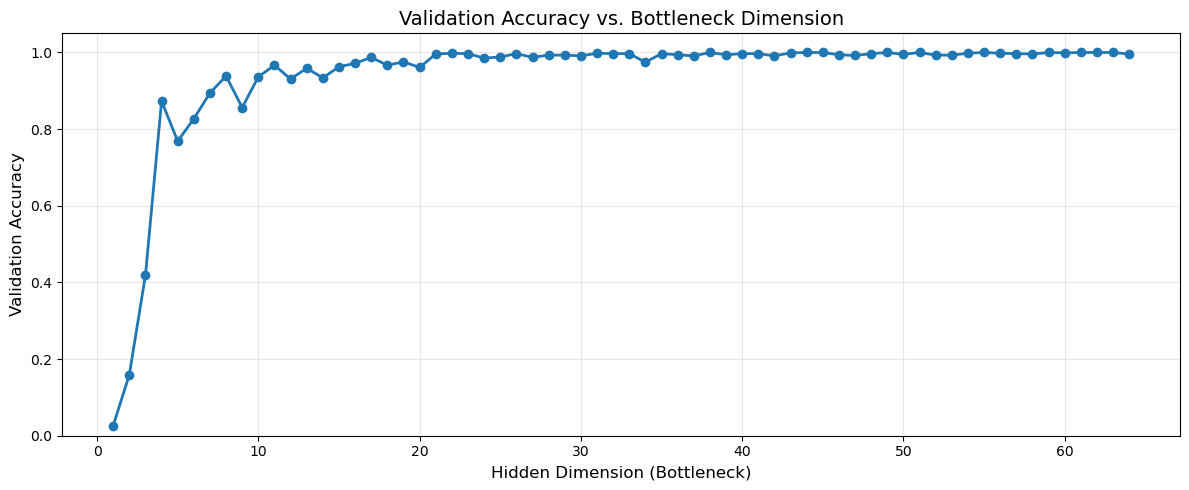

In [3]:
if len(val_acc) > 0:
    dims_sorted = sorted(list(val_acc.keys()), reverse=True)
    accs_sorted = [val_acc[d] for d in dims_sorted]
    
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(dims_sorted, accs_sorted, 'o-', linewidth=2, markersize=6)
    ax.set_xlabel('Hidden Dimension (Bottleneck)', fontsize=12)
    ax.set_ylabel('Validation Accuracy', fontsize=12)
    ax.set_title('Validation Accuracy vs. Bottleneck Dimension', fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 1.05])
    plt.tight_layout()
    plt.show()
else:
    print('No validation accuracies available.')

## Side-by-Side Similarity Heatmaps

Compare all three similarity metrics at once.

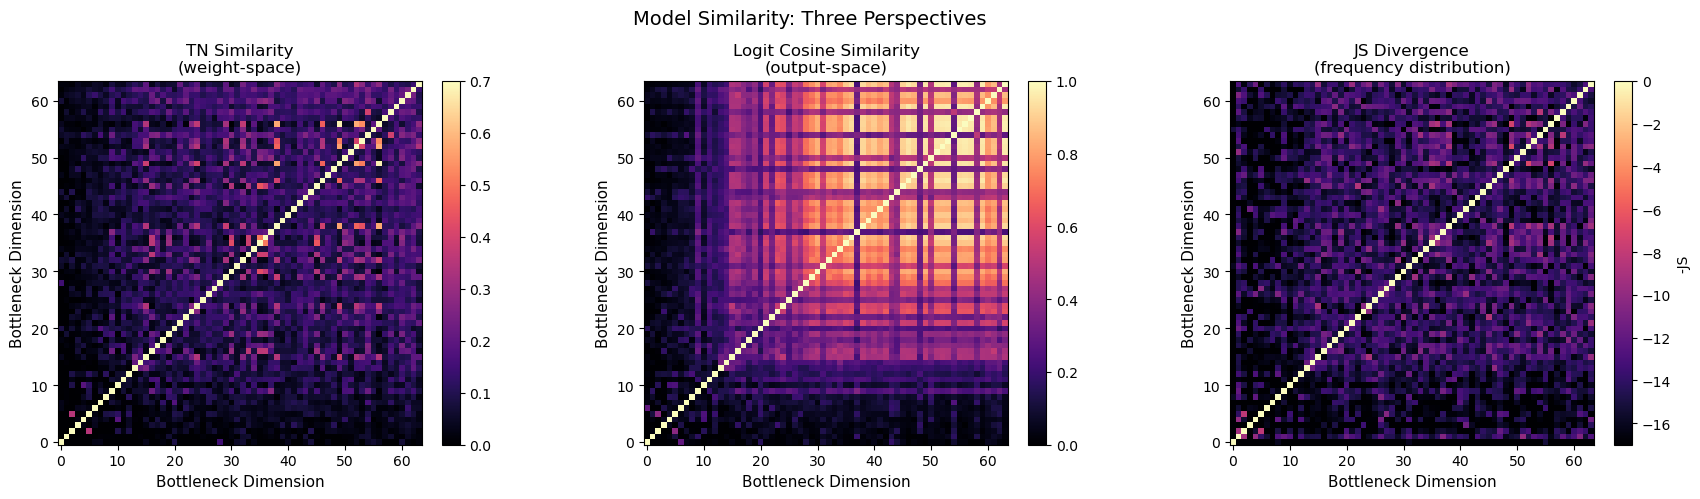

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# TN Similarity
ax1 = axes[0]
im1 = ax1.imshow(tn_sim_mat, cmap='magma', vmin=0, vmax=0.7, origin='lower')
ax1.set_xlabel('Bottleneck Dimension', fontsize=11)
ax1.set_ylabel('Bottleneck Dimension', fontsize=11)
ax1.set_title('TN Similarity\n(weight-space)', fontsize=12)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

# Logit Cosine Similarity
ax2 = axes[1]
im2 = ax2.imshow(act_sim_mat, cmap='magma', vmin=0, vmax=1.0, origin='lower')
ax2.set_xlabel('Bottleneck Dimension', fontsize=11)
ax2.set_ylabel('Bottleneck Dimension', fontsize=11)
ax2.set_title('Logit Cosine Similarity\n(output-space)', fontsize=12)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

# JS Divergence (negated for visual consistency - lower divergence = more similar)
ax3 = axes[2]
im3 = ax3.imshow(-js_div_mat, cmap='magma', origin='lower', vmin=-17)
ax3.set_xlabel('Bottleneck Dimension', fontsize=11)
ax3.set_ylabel('Bottleneck Dimension', fontsize=11)
ax3.set_title('JS Divergence\n(frequency distribution)', fontsize=12)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label='-JS')

plt.suptitle('Model Similarity: Three Perspectives', fontsize=14)
plt.tight_layout()
plt.show()

## Individual Heatmap Exploration

Interactive exploration with adjustable color scales.

In [ ]:
def plot_similarity_heatmap(metric='TN', vmin=0.0, vmax=1.0):
    """Plot a single similarity heatmap with adjustable parameters."""
    fig, ax = plt.subplots(figsize=(8, 6))
    
    if metric == 'TN':
        data = tn_sim_mat
        title = 'TN Similarity (weight-space)'
    elif metric == 'Logit':
        data = act_sim_mat
        title = 'Logit Cosine Similarity (output-space)'
    else:  # JS
        data = -js_div_mat  # Negate for visual consistency
        title = 'Negative JS Divergence (frequency)'
    
    im = ax.imshow(data, cmap='magma', vmin=vmin, vmax=vmax, origin='lower')
    ax.set_xlabel('Bottleneck Dimension', fontsize=12)
    ax.set_ylabel('Bottleneck Dimension', fontsize=12)
    ax.set_title(title, fontsize=14)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Create interactive widgets
metric_dropdown = widgets.Dropdown(
    options=['TN', 'Logit', 'JS'],
    value='TN',
    description='Metric:'
)
vmin_slider = widgets.FloatSlider(min=-20, max=1, step=0.1, value=0.0, description='vmin')
vmax_slider = widgets.FloatSlider(min=0, max=1, step=0.1, value=1.0, description='vmax')

out = widgets.interactive_output(
    plot_similarity_heatmap,
    {'metric': metric_dropdown, 'vmin': vmin_slider, 'vmax': vmax_slider}
)
display(widgets.VBox([widgets.HBox([metric_dropdown, vmin_slider, vmax_slider]), out]))

## Correlation Analysis Between Metrics

How do the different similarity metrics relate to each other?

In [6]:
# Flatten upper triangular parts for correlation (exclude diagonal)
upper_idx = np.triu_indices(P, k=1)

tn_flat = tn_sim_mat[upper_idx]
act_flat = act_sim_mat[upper_idx]
js_flat = js_div_mat[upper_idx]

# Compute correlations
corr_tn_act = np.corrcoef(tn_flat, act_flat)[0, 1]
corr_tn_js = np.corrcoef(tn_flat, -js_flat)[0, 1]  # Negate JS for positive correlation
corr_act_js = np.corrcoef(act_flat, -js_flat)[0, 1]

print('Pairwise Correlations (upper triangular, excluding diagonal):')
print(f'  TN vs Logit: {corr_tn_act:.4f}')
print(f'  TN vs -JS:   {corr_tn_js:.4f}')
print(f'  Logit vs -JS: {corr_act_js:.4f}')

Pairwise Correlations (upper triangular, excluding diagonal):
  TN vs Logit: 0.5523
  TN vs -JS:   0.6196
  Logit vs -JS: 0.4427


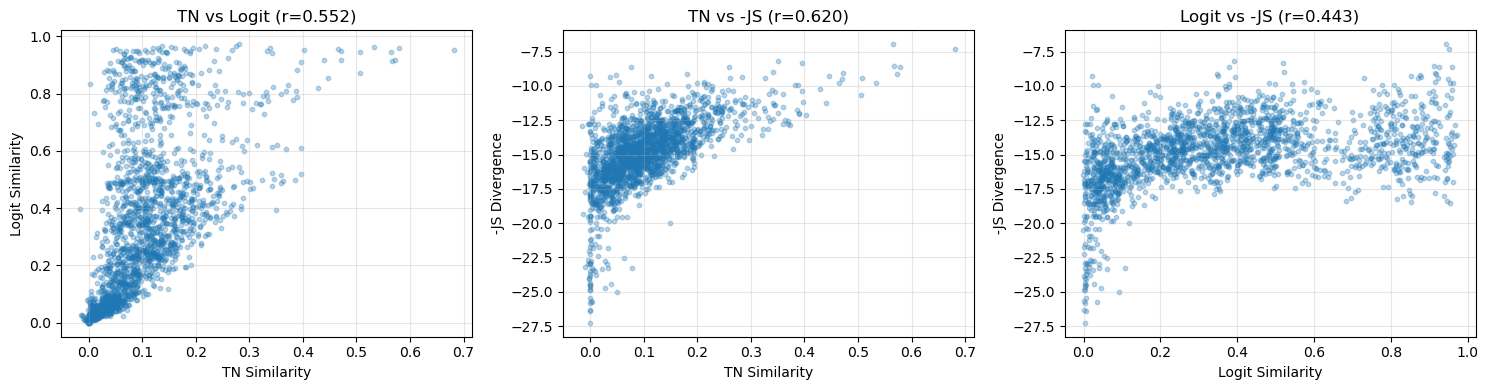

In [7]:
# Scatter plots of metric relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

ax1 = axes[0]
ax1.scatter(tn_flat, act_flat, alpha=0.3, s=10)
ax1.set_xlabel('TN Similarity')
ax1.set_ylabel('Logit Similarity')
ax1.set_title(f'TN vs Logit (r={corr_tn_act:.3f})')
ax1.grid(True, alpha=0.3)

ax2 = axes[1]
ax2.scatter(tn_flat, -js_flat, alpha=0.3, s=10)
ax2.set_xlabel('TN Similarity')
ax2.set_ylabel('-JS Divergence')
ax2.set_title(f'TN vs -JS (r={corr_tn_js:.3f})')
ax2.grid(True, alpha=0.3)

ax3 = axes[2]
ax3.scatter(act_flat, -js_flat, alpha=0.3, s=10)
ax3.set_xlabel('Logit Similarity')
ax3.set_ylabel('-JS Divergence')
ax3.set_title(f'Logit vs -JS (r={corr_act_js:.3f})')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Similarity Profile by Bottleneck Dimension

How similar is each model to all others? Compare similarity profiles.

In [8]:
def plot_similarity_profile(dim_idx=P-1):
    """Plot similarity profile for a given bottleneck dimension."""
    d = dim_idx + 1  # Convert to 1-indexed dimension
    dims = np.arange(1, P+1)
    
    fig, ax = plt.subplots(figsize=(12, 5))
    
    ax.plot(dims, tn_sim_mat[dim_idx], 'o-', label='TN', markersize=4)
    ax.plot(dims, act_sim_mat[dim_idx], 's-', label='Logit', markersize=4)
    ax.plot(dims, -js_div_mat[dim_idx] / 17, '^-', label='-JS/17', markersize=4)  # Scaled
    
    ax.axvline(d, color='red', linestyle='--', alpha=0.5, label=f'd={d}')
    ax.set_xlabel('Comparison Bottleneck Dimension')
    ax.set_ylabel('Similarity')
    ax.set_title(f'Similarity Profile for d_hidden={d}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

dim_slider = widgets.IntSlider(min=0, max=P-1, step=1, value=P-1, description='dim_idx')
out = widgets.interactive_output(plot_similarity_profile, {'dim_idx': dim_slider})
display(dim_slider, out)

IntSlider(value=63, description='dim_idx', max=63)

Output()

## Summary Statistics

In [9]:
print('Summary Statistics (excluding diagonal):')
print('\nTN Similarity:')
print(f'  Mean: {tn_flat.mean():.4f}')
print(f'  Std:  {tn_flat.std():.4f}')
print(f'  Range: [{tn_flat.min():.4f}, {tn_flat.max():.4f}]')

print('\nLogit Cosine Similarity:')
print(f'  Mean: {act_flat.mean():.4f}')
print(f'  Std:  {act_flat.std():.4f}')
print(f'  Range: [{act_flat.min():.4f}, {act_flat.max():.4f}]')

print('\nJS Divergence:')
print(f'  Mean: {js_flat.mean():.4f}')
print(f'  Std:  {js_flat.std():.4f}')
print(f'  Range: [{js_flat.min():.4f}, {js_flat.max():.4f}]')

Summary Statistics (excluding diagonal):

TN Similarity:
  Mean: 0.1031
  Std:  0.0805
  Range: [-0.0159, 0.6815]

Logit Cosine Similarity:
  Mean: 0.3566
  Std:  0.2705
  Range: [-0.0009, 0.9721]

JS Divergence:
  Mean: 14.8710
  Std:  2.4648
  Range: [6.9629, 27.2628]


---

# Metric Comparison Analysis

Convert similarities to proper distance metrics and compare them using:
1. **Pearson correlation** - Global linear relationship
2. **Procrustes stress** - Scale-invariant distortion measure
3. **Neighborhood preservation** - Local structure agreement (k-NN overlap, Jaccard, Trustworthiness)

## Convert Similarities to Distance Metrics

For inner product-based similarities:
$$d(A,B)^2 = \|A\|^2 + \|B\|^2 - 2\langle A | B \rangle$$

For cosine similarity (normalized vectors):
$$d^2 = 2(1 - \cos\theta)$$

For JS divergence, $\sqrt{\text{JS}}$ is a proper metric.

In [ ]:
# Convert to distance metrics
D_tn = cosine_similarity_to_metric(tn_sim_mat)
D_act = cosine_similarity_to_metric(act_sim_mat)
D_js = divergence_to_metric(js_div_mat)

print('Distance matrices computed:')
print(f'  D_tn:  range [{D_tn.min():.4f}, {D_tn.max():.4f}]')
print(f'  D_act: range [{D_act.min():.4f}, {D_act.max():.4f}]')
print(f'  D_js:  range [{D_js.min():.4f}, {D_js.max():.4f}]')

In [ ]:
# Visualize distance matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax1 = axes[0]
im1 = ax1.imshow(D_tn, cmap='viridis', origin='lower')
ax1.set_xlabel('Bottleneck Dimension', fontsize=11)
ax1.set_ylabel('Bottleneck Dimension', fontsize=11)
ax1.set_title('TN Distance\n(weight-space)', fontsize=12)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

ax2 = axes[1]
im2 = ax2.imshow(D_act, cmap='viridis', origin='lower')
ax2.set_xlabel('Bottleneck Dimension', fontsize=11)
ax2.set_ylabel('Bottleneck Dimension', fontsize=11)
ax2.set_title('Logit Distance\n(output-space)', fontsize=12)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

ax3 = axes[2]
im3 = ax3.imshow(D_js, cmap='viridis', origin='lower')
ax3.set_xlabel('Bottleneck Dimension', fontsize=11)
ax3.set_ylabel('Bottleneck Dimension', fontsize=11)
ax3.set_title('sqrt(JS) Distance\n(frequency)', fontsize=12)
fig.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)

plt.suptitle('Distance Matrices (induced from similarities)', fontsize=14)
plt.tight_layout()
plt.show()

## Global Comparison: Correlation and Stress

**Procrustes Stress** measures how well one distance matrix approximates another:
$$\text{stress}(D, D') = \sqrt{\frac{\sum_{i<j}(D_{ij} - \alpha D'_{ij})^2}{\sum_{i<j} D_{ij}^2}}$$

where $\alpha$ is the optimal scaling factor.

In [ ]:
# Compute all pairwise comparisons
metrics = {'TN': D_tn, 'Logit': D_act, 'JS': D_js}
metric_names = list(metrics.keys())

print('Global Metric Comparison')
print('=' * 60)

print('\nPearson Correlation (distance matrices):')
for i, name1 in enumerate(metric_names):
    for name2 in metric_names[i+1:]:
        corr = pearson_correlation(metrics[name1], metrics[name2])
        print(f'  {name1} vs {name2}: {corr:.4f}')

print('\nProcrustes Stress (D1 approximated by scaled D2):')
for i, name1 in enumerate(metric_names):
    for name2 in metric_names[i+1:]:
        stress = compute_stress(metrics[name1], metrics[name2])
        alpha = compute_optimal_scale(metrics[name1], metrics[name2])
        print(f'  {name1} vs {name2}: stress={stress:.4f}, optimal_scale={alpha:.4f}')

## Neighborhood Preservation Analysis

For "similar models should be close," local structure matters more than global correlation.

**k-NN Overlap**: Average fraction of shared neighbors
$$\text{overlap} = \frac{1}{N} \sum_i \frac{|\text{NN}_k^{D_1}(i) \cap \text{NN}_k^{D_2}(i)|}{k}$$

**Jaccard Index**: $\frac{|A \cap B|}{|A \cup B|}$

**Trustworthiness**: Penalizes false neighbors (close in D2 but far in D1)

**Continuity**: Penalizes missing neighbors (close in D1 but far in D2)

In [ ]:
# Compute neighborhood preservation for various k values
k_values = [1, 2, 3, 5, 10, 15, 20, 30, 40, 50]

# Store results for plotting
results = {}
pairs = [('TN', 'Logit'), ('TN', 'JS'), ('Logit', 'JS')]

for name1, name2 in pairs:
    D1, D2 = metrics[name1], metrics[name2]
    results[(name1, name2)] = {
        'knn_overlap': [compute_knn_overlap(D1, D2, k) for k in k_values],
        'jaccard': [compute_jaccard_index(D1, D2, k) for k in k_values],
        'trustworthiness': [compute_trustworthiness(D1, D2, k) for k in k_values],
        'continuity': [compute_continuity(D1, D2, k) for k in k_values],
    }

print('Neighborhood preservation analysis computed for k =', k_values)

In [ ]:
# Plot k-NN overlap curves
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# k-NN Overlap
ax = axes[0, 0]
for (name1, name2), res in results.items():
    ax.plot(k_values, res['knn_overlap'], 'o-', label=f'{name1} vs {name2}', markersize=5)
ax.set_xlabel('k (number of neighbors)')
ax.set_ylabel('Average k-NN Overlap')
ax.set_title('k-NN Overlap vs k')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Jaccard Index
ax = axes[0, 1]
for (name1, name2), res in results.items():
    ax.plot(k_values, res['jaccard'], 'o-', label=f'{name1} vs {name2}', markersize=5)
ax.set_xlabel('k (number of neighbors)')
ax.set_ylabel('Average Jaccard Index')
ax.set_title('Jaccard Index vs k')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Trustworthiness
ax = axes[1, 0]
for (name1, name2), res in results.items():
    ax.plot(k_values, res['trustworthiness'], 'o-', label=f'{name1} vs {name2}', markersize=5)
ax.set_xlabel('k (number of neighbors)')
ax.set_ylabel('Trustworthiness')
ax.set_title('Trustworthiness vs k (higher = fewer false neighbors)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Continuity
ax = axes[1, 1]
for (name1, name2), res in results.items():
    ax.plot(k_values, res['continuity'], 'o-', label=f'{name1} vs {name2}', markersize=5)
ax.set_xlabel('k (number of neighbors)')
ax.set_ylabel('Continuity')
ax.set_title('Continuity vs k (higher = fewer missing neighbors)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.suptitle('Neighborhood Preservation Analysis', fontsize=14)
plt.tight_layout()
plt.show()

## Comprehensive Comparison Summary

In [ ]:
# Print detailed comparison for each pair
for name1, name2 in pairs:
    res = compare_metrics(metrics[name1], metrics[name2], name1, name2, k_values)
    print_comparison_results(res)

In [ ]:
# Create summary table
print('\n' + '=' * 70)
print('SUMMARY TABLE')
print('=' * 70)
print(f'{"Metric Pair":<20} {"Pearson":<10} {"Stress":<10} {"k=5 Overlap":<12} {"k=10 Overlap":<12}')
print('-' * 70)

for (name1, name2), res in results.items():
    pair_name = f'{name1} vs {name2}'
    corr = pearson_correlation(metrics[name1], metrics[name2])
    stress = compute_stress(metrics[name1], metrics[name2])
    k5_idx = k_values.index(5)
    k10_idx = k_values.index(10)
    print(f'{pair_name:<20} {corr:<10.4f} {stress:<10.4f} {res["knn_overlap"][k5_idx]:<12.4f} {res["knn_overlap"][k10_idx]:<12.4f}')

print('=' * 70)

## Interpretation Guide

**Pearson Correlation**: How linearly related are the distances? High correlation means the metrics rank model pairs similarly.

**Procrustes Stress**: How well does one metric reproduce the other after optimal scaling? Lower is better (0 = perfect match).

**k-NN Overlap**: What fraction of nearest neighbors are shared? Higher means the metrics agree on local structure.

**Trustworthiness**: Are neighbors in metric 2 also neighbors in metric 1? Low trustworthiness = many "false neighbors".

**Continuity**: Are neighbors in metric 1 preserved in metric 2? Low continuity = important neighbors are "lost".